In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

import pdcast as pdc

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

import mscproject.features as feats
import mscproject.preprocess as pre
import mscproject.pygloaders as pgl
from mscproject.metrics import EvalMetrics
import catboost as cb

In [2]:
# Read config.
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

features_path = conf_dict["features_path"]

In [3]:
# Load features for data split.
def load_features(path_root):
    companies_df = pd.read_parquet(conf_dict["companies_features"])
    persons_df = pd.read_parquet(conf_dict["persons_features"])
    return companies_df, persons_df

In [4]:
companies_df, persons_df = load_features(features_path)

In [5]:
companies_df.describe().T

,count,mean,std,min,25%,50%,75%,max
component,94054.0,2.025976e+03,2.262538e+03,0.000000,6.000000,1037.000000,3962.000000,6863.000000
indegree,94054.0,1.402386e+00,6.659484e-01,0.000000,1.000000,1.000000,2.000000,19.000000
outdegree,94054.0,5.733940e-01,3.103410e+00,0.000000,0.000000,0.000000,0.000000,460.000000
closeness,94054.0,1.405177e-05,6.167987e-06,0.000000,0.000008,0.000014,0.000016,0.000152
clustering,94054.0,5.096428e-03,4.470286e-02,0.000000,0.000000,0.000000,0.000000,1.000000
pagerank,94054.0,8.820028e-06,3.752041e-06,0.000006,0.000006,0.000007,0.000010,0.000090
neighbourhood_count,94054.0,1.364227e+00,2.981551e+00,1.000000,1.000000,1.000000,1.000000,460.000000
neighbourhood_indegree_min,94054.0,1.397431e+00,6.475961e-01,1.000000,1.000000,1.000000,2.000000,15.000000
neighbourhood_outdegree_min,94054.0,7.336211e-02,8.097613e-01,0.000000,0.000000,0.000000,0.000000,105.000000
neighbourhood_closeness_min,94054.0,1.492217e-05,6.417487e-06,0.000000,0.000011,0.000014,0.000018,0.000120


In [6]:
common_cols = set(companies_df.columns) & set(persons_df.columns)
drop_cols = ["id", "name", "component"]
select_cols = sorted(common_cols.difference(drop_cols))

target = "is_anomalous"

entities_df = pd.concat([companies_df, persons_df], axis=0)[list(common_cols)]

In [7]:
masks = pgl.get_data_split_masks(entities_df)

In [8]:
train_df = entities_df.loc[list(masks.train.numpy())].drop(drop_cols, axis=1)
valid_df = entities_df.loc[list(masks.val.numpy())].drop(drop_cols, axis=1)
test_df = entities_df.loc[list(masks.test.numpy())].drop(drop_cols, axis=1)

In [9]:
train_df

,neighbourhood_outdegree_max,neighbourhood_clustering_mean,clustering,indegree,neighbourhood_pagerank_sum,neighbourhood_pagerank_max,neighbourhood_indegree_mean,isCompany,neighbourhood_clustering_min,neighbourhood_indegree_max,...,neighbourhood_count,neighbourhood_pagerank_min,neighbourhood_closeness_std,outdegree,neighbourhood_clustering_max,neighbourhood_closeness_min,neighbourhood_indegree_sum,neighbourhood_clustering_std,neighbourhood_outdegree_std,neighbourhood_closeness_max
0,0.0,0.0,0.0,1,0.000012,0.000012,2.0,True,0.0,2.0,...,1.0,0.000012,0.000000,1,0.0,0.000021,2.0,0.0,0.0,0.000021
1,0.0,0.0,0.0,1,0.000007,0.000007,1.0,True,0.0,1.0,...,1.0,0.000007,0.000000,0,0.0,0.000011,1.0,0.0,0.0,0.000011
2,0.0,0.0,0.0,1,0.000007,0.000007,1.0,True,0.0,1.0,...,1.0,0.000007,0.000000,0,0.0,0.000008,1.0,0.0,0.0,0.000008
3,0.0,0.0,0.0,2,0.000011,0.000011,2.0,True,0.0,2.0,...,1.0,0.000011,0.000000,0,0.0,0.000016,2.0,0.0,0.0,0.000016
4,0.0,0.0,0.0,2,0.000028,0.000015,2.5,True,0.0,3.0,...,2.0,0.000013,0.000005,2,0.0,0.000021,5.0,0.0,0.0,0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30875,0.0,0.0,0.0,0,0.000016,0.000009,1.5,False,0.0,2.0,...,2.0,0.000008,0.000004,2,0.0,0.000008,3.0,0.0,0.0,0.000016
30876,1.0,0.0,0.0,0,0.000016,0.000016,3.0,False,0.0,3.0,...,1.0,0.000016,0.000000,1,0.0,0.000024,3.0,0.0,0.0,0.000024
30877,0.0,0.0,0.0,0,0.000011,0.000011,2.0,False,0.0,2.0,...,1.0,0.000011,0.000000,1,0.0,0.000016,2.0,0.0,0.0,0.000016
30878,6.0,0.0,0.0,0,0.000010,0.000010,1.0,False,0.0,1.0,...,1.0,0.000010,0.000000,1,0.0,0.000008,1.0,0.0,0.0,0.000008


In [10]:
train_df.query("isCompany == False and indegree > 0")

,neighbourhood_outdegree_max,neighbourhood_clustering_mean,clustering,indegree,neighbourhood_pagerank_sum,neighbourhood_pagerank_max,neighbourhood_indegree_mean,isCompany,neighbourhood_clustering_min,neighbourhood_indegree_max,...,neighbourhood_count,neighbourhood_pagerank_min,neighbourhood_closeness_std,outdegree,neighbourhood_clustering_max,neighbourhood_closeness_min,neighbourhood_indegree_sum,neighbourhood_clustering_std,neighbourhood_outdegree_std,neighbourhood_closeness_max


In [11]:
# Create train, test, and valid pools for CatBoost.

cat_features = ["isCompany"]

X_train = train_df.drop(target, axis=1)
y_train = train_df[target].astype(np.int8)

X_valid = valid_df.drop(target, axis=1)
y_valid = valid_df[target].astype(np.int8)

X_test = test_df.drop(target, axis=1)
y_test = test_df[target].astype(np.int8)

In [22]:
train_pool = cb.Pool(
    X_train.to_numpy(),
    y_train.to_numpy(),
    cat_features=cat_features,
    feature_names=X_train.columns.to_list(),
)

val_pool = cb.Pool(
    X_valid.to_numpy(),
    y_valid.to_numpy(),
    cat_features=cat_features,
    feature_names=X_valid.columns.to_list(),
)

trail_val_pool = cb.Pool(
    pd.concat([X_train, X_valid]).to_numpy(),
    pd.concat([y_train, y_valid]).to_numpy(),
    cat_features=cat_features,
    feature_names=X_test.columns.to_list(),
)

test_pool = cb.Pool(
    X_test.to_numpy(),
    y_test.to_numpy(),
    cat_features=cat_features,
    feature_names=X_test.columns.to_list(),
)

In [23]:
class_weights = {0: 1, 1: 10}

In [26]:
# Create CatBoost model.
clf = cb.CatBoostClassifier(
    iterations=2001,
    # learning_rate=0.1,
    depth=6,
    # eval_metric="Accuracy",
    class_weights=class_weights,
    random_seed=42,
    loss_function="Logloss",
    eval_metric="PRAUC",
)


# Fit model.
clf.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    verbose=200,
)

best_iter = clf.get_best_iteration()

Learning rate set to 0.074799
0:	learn: 0.6350553	test: 0.3941304	best: 0.3941304 (0)	total: 11.3ms	remaining: 22.7s
200:	learn: 0.6916891	test: 0.4905832	best: 0.4922246 (170)	total: 2.99s	remaining: 26.7s
400:	learn: 0.7248161	test: 0.4964216	best: 0.4974998 (381)	total: 5.97s	remaining: 23.8s
600:	learn: 0.7430670	test: 0.4995269	best: 0.5008895 (551)	total: 9.03s	remaining: 21s
800:	learn: 0.7571869	test: 0.5012272	best: 0.5023422 (643)	total: 12.3s	remaining: 18.4s
1000:	learn: 0.7687788	test: 0.5045668	best: 0.5048914 (987)	total: 15.2s	remaining: 15.2s
1200:	learn: 0.7777050	test: 0.5008956	best: 0.5059733 (1077)	total: 18.4s	remaining: 12.3s
1400:	learn: 0.7851736	test: 0.5019545	best: 0.5059733 (1077)	total: 21.6s	remaining: 9.25s
1600:	learn: 0.7913367	test: 0.5014302	best: 0.5059733 (1077)	total: 24.7s	remaining: 6.17s
1800:	learn: 0.7967164	test: 0.5021191	best: 0.5059733 (1077)	total: 27.8s	remaining: 3.08s
2000:	learn: 0.8013417	test: 0.5004615	best: 0.5059733 (1077)	tota

In [28]:
# Fit model on all data.
clf = cb.CatBoostClassifier(
    iterations=best_iter,
    depth=6,
    # eval_metric="Accuracy",
    class_weights=class_weights,
    random_seed=42,
    loss_function="Logloss",
    eval_metric="PRAUC",
)

clf.fit(trail_val_pool, verbose=200)

Learning rate set to 0.07361
0:	learn: 0.6239471	total: 14.6ms	remaining: 15.7s
200:	learn: 0.6829917	total: 2.92s	remaining: 12.7s
400:	learn: 0.7155288	total: 6.07s	remaining: 10.2s
600:	learn: 0.7349494	total: 9.11s	remaining: 7.21s
800:	learn: 0.7478690	total: 12.3s	remaining: 4.24s
1000:	learn: 0.7589169	total: 15.5s	remaining: 1.18s
1076:	learn: 0.7621210	total: 16.7s	remaining: 0us


In [29]:
# Print confusion matrix.
y_pred = clf.predict(test_pool)
print(pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]))

Predicted     0     1
Actual               
0          3315  3785
1           133   429


In [30]:
# Evaluate model.
y_test_pred = np.array([x[1] for x in clf.predict_proba(test_pool)])
eval_metrics = EvalMetrics.from_numpy(y_test_pred, y_test.to_numpy())
print(eval_metrics)

loss: 0.589, acc: 0.927, prc: 0.102, rec: 0.763, f1: 0.180, auc: 0.646, aprc: 0.107


In [31]:
# Get Shapley values.
shap_values = clf.get_feature_importance(test_pool, type="ShapValues")[:, 1:]


import shap

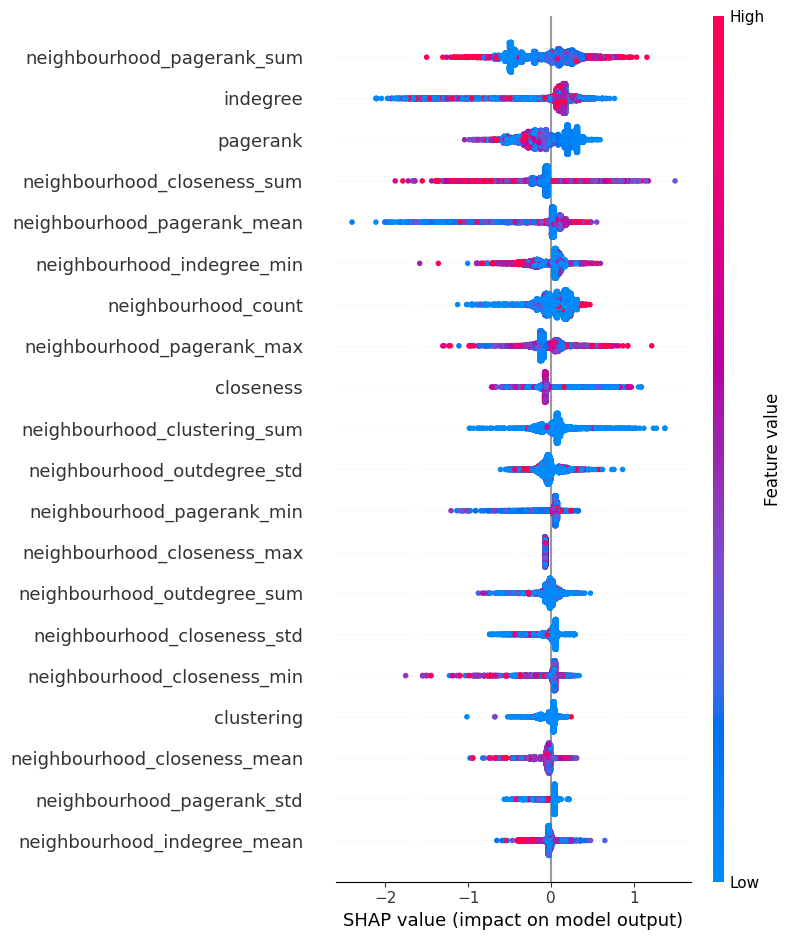

In [32]:
shap.summary_plot(shap_values, X_test)

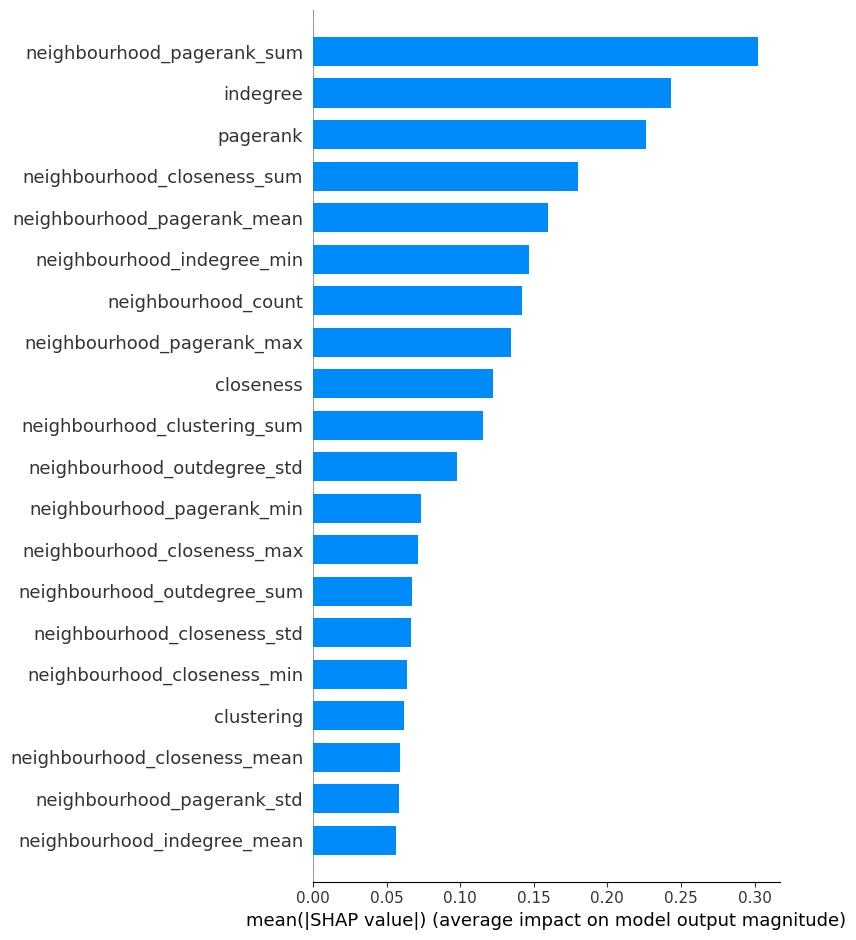

In [33]:
# Plot partial dependence plots.
shap.summary_plot(shap_values, X_test, plot_type="bar")

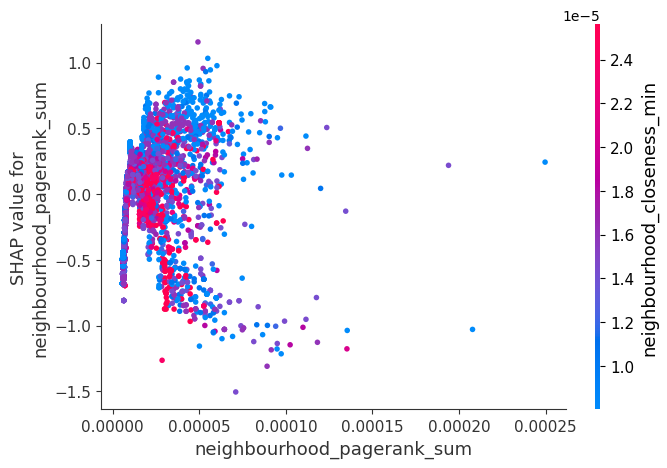

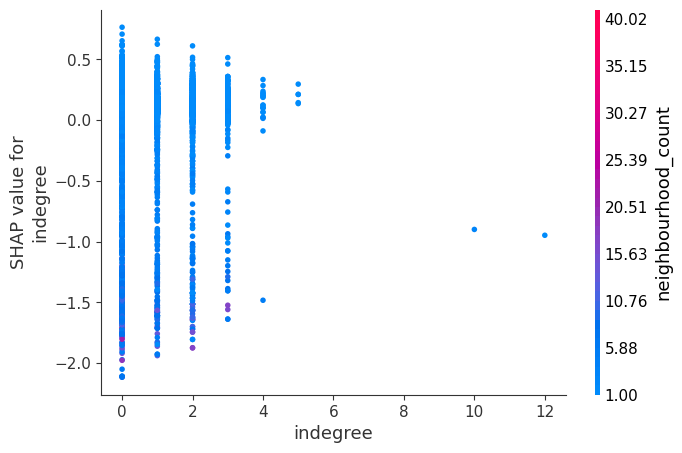

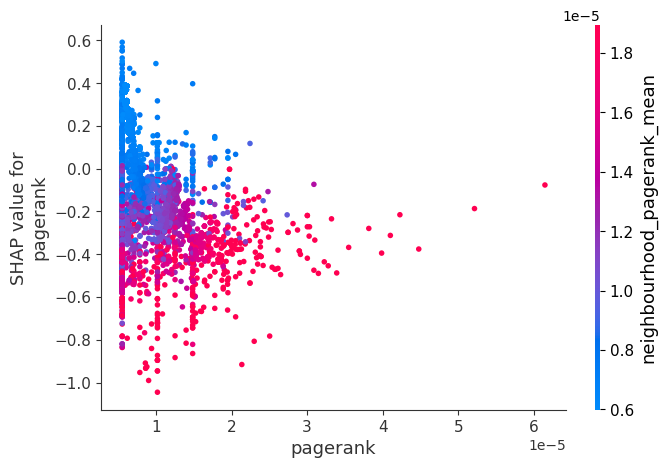

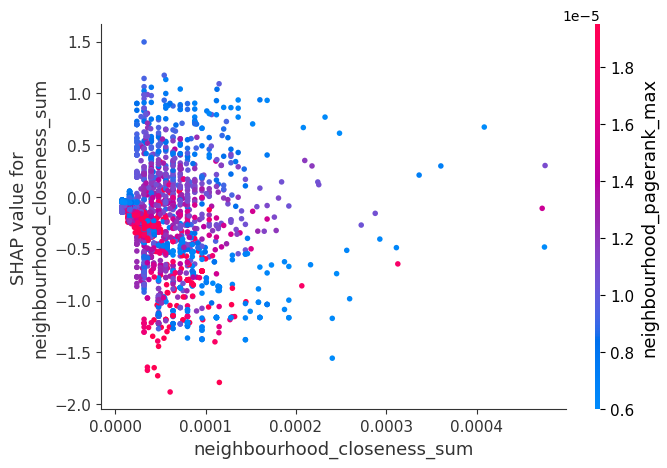

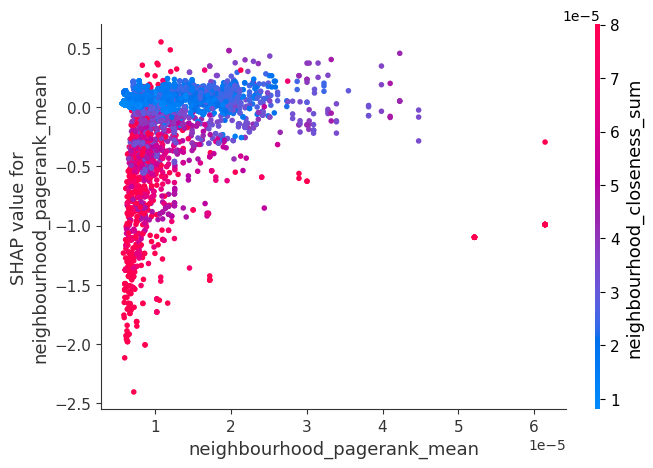

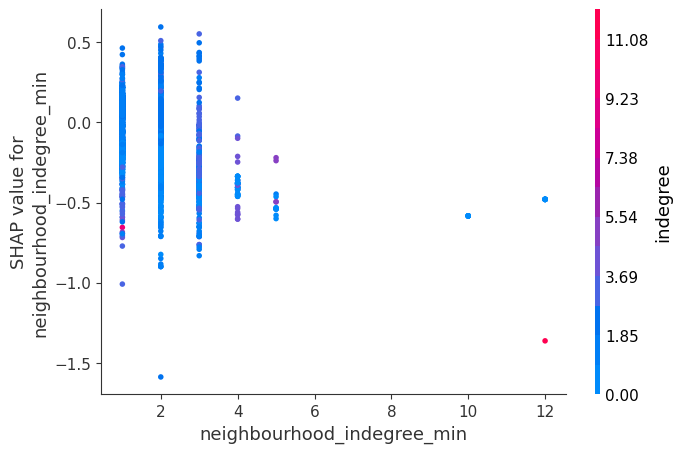

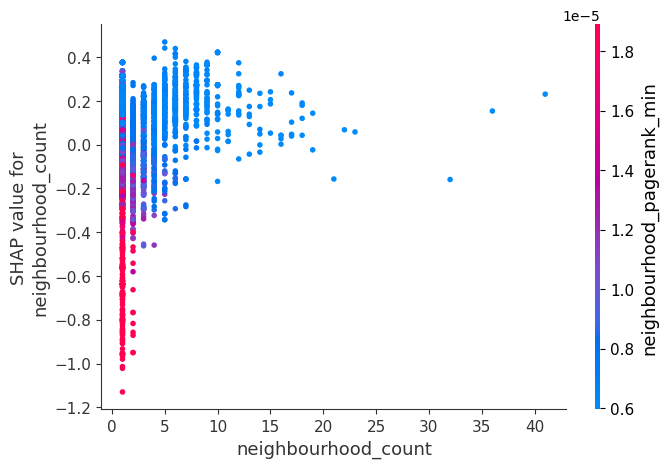

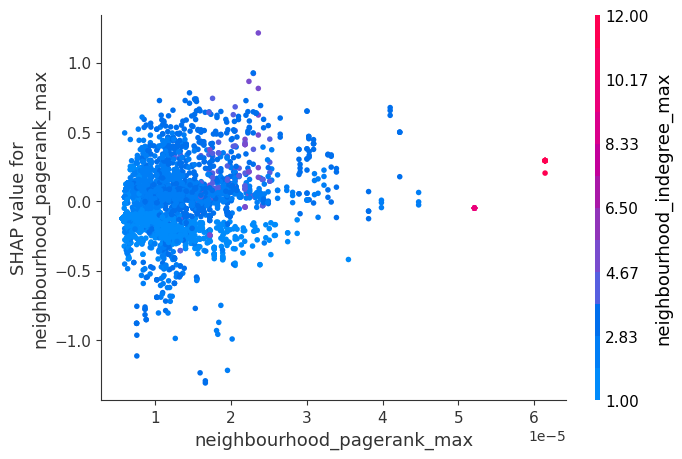

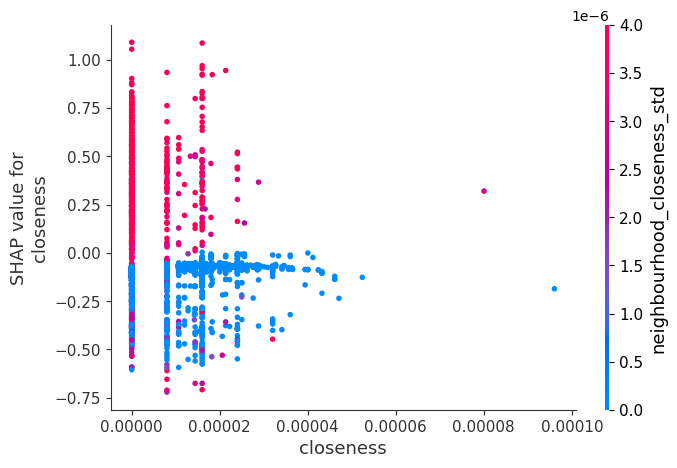

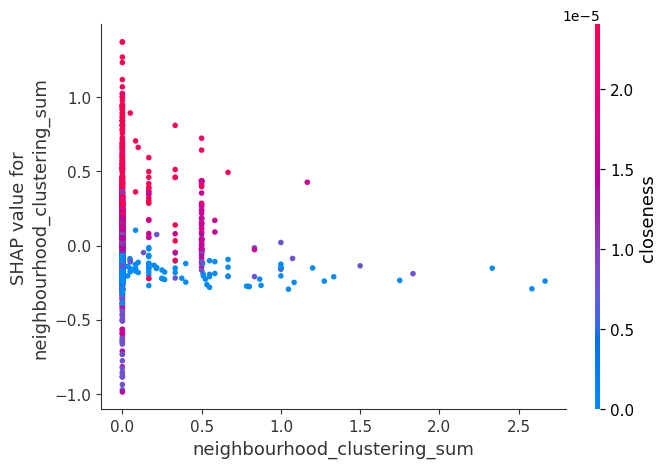

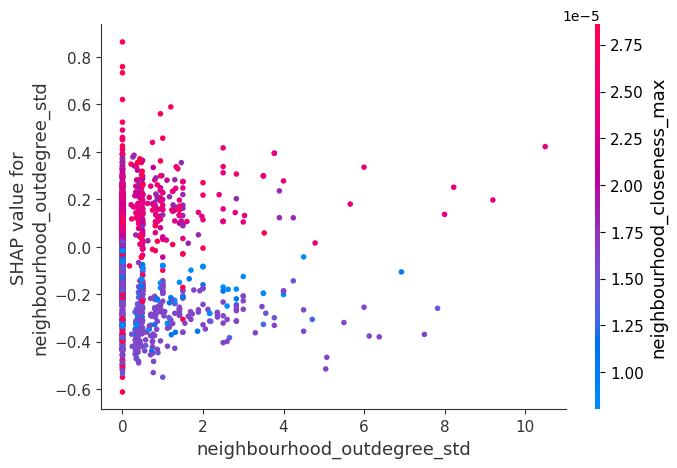

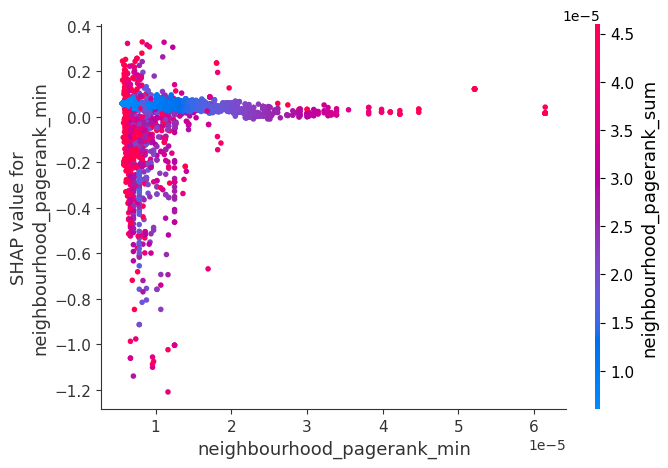

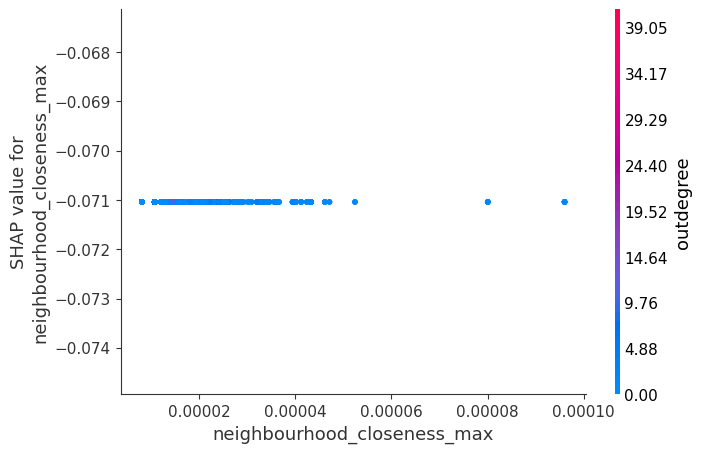

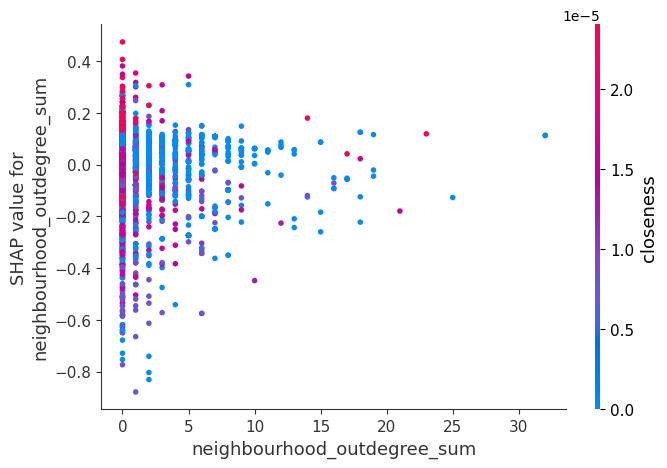

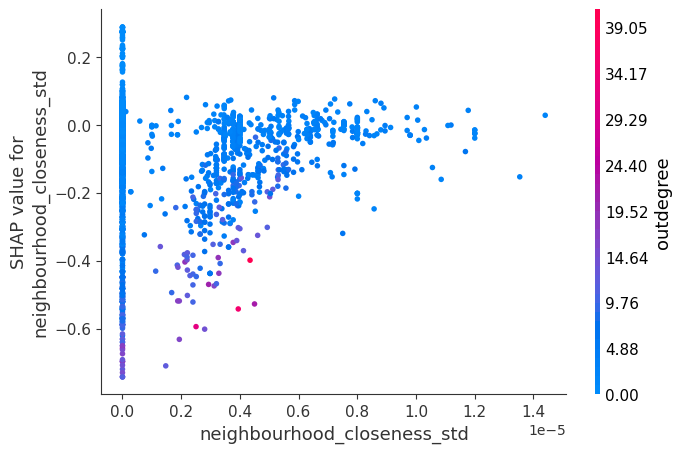

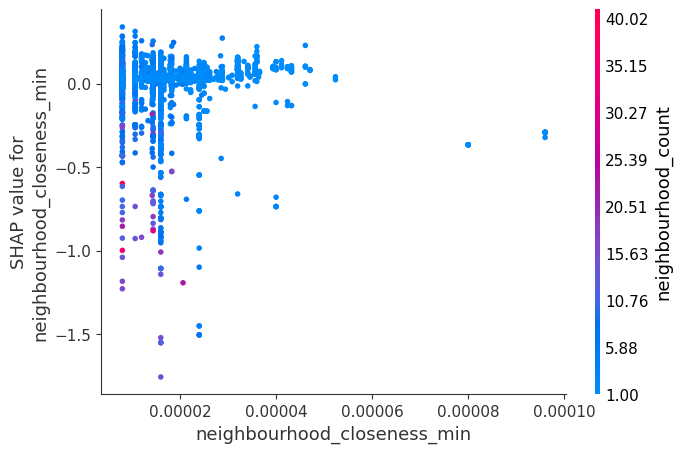

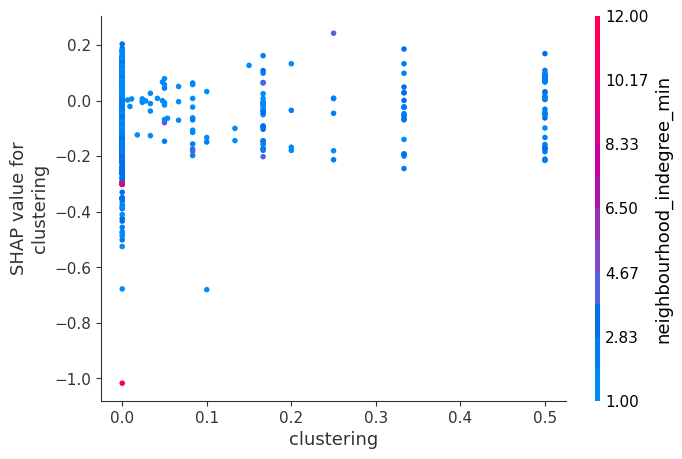

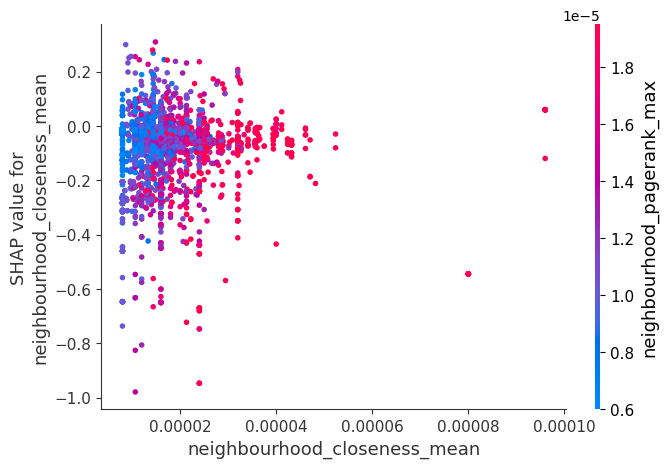

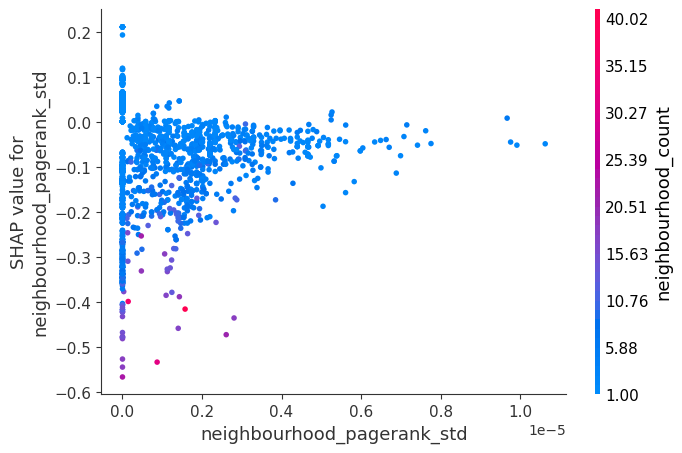

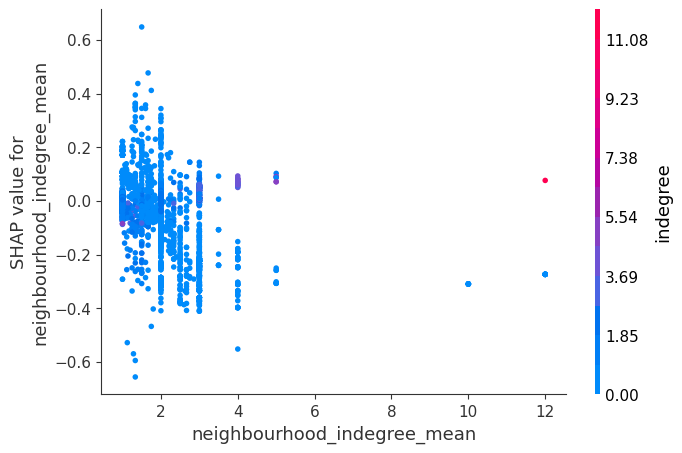

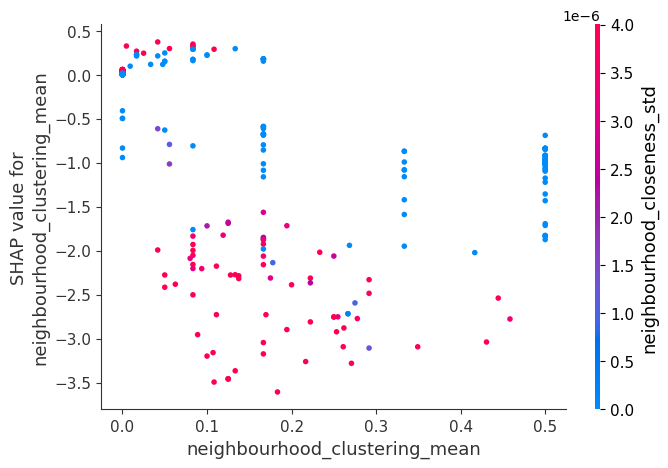

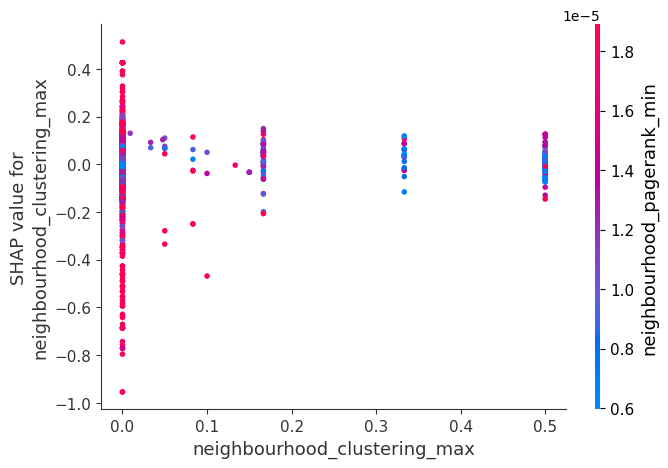

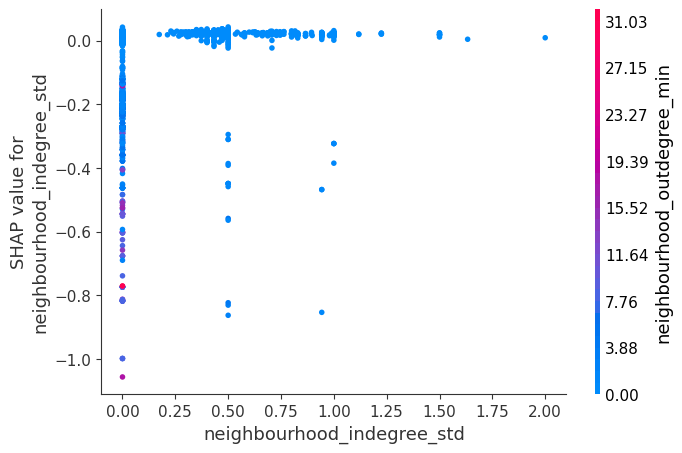

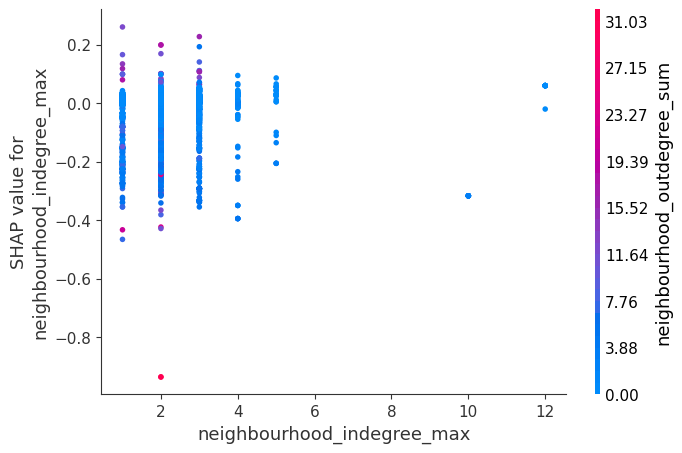

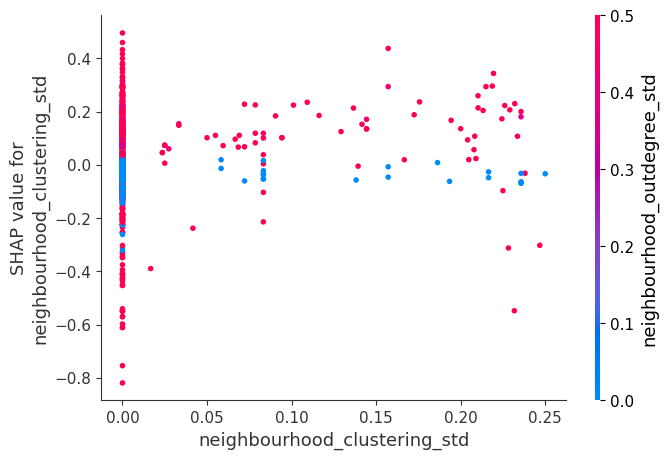

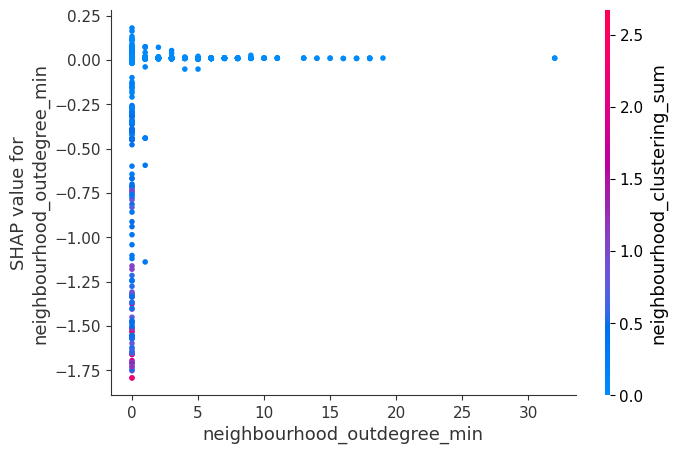

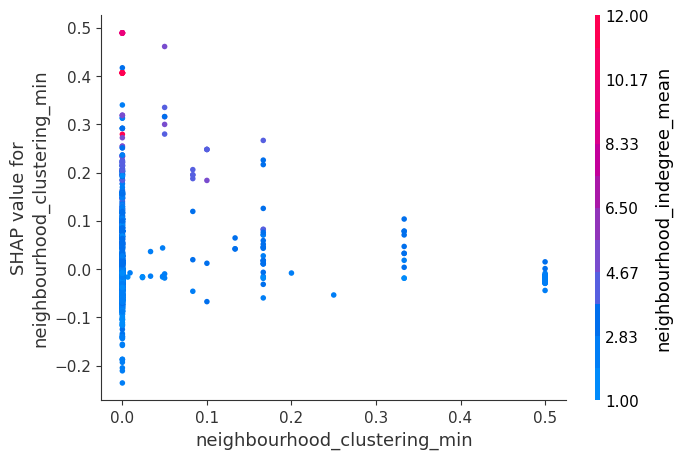

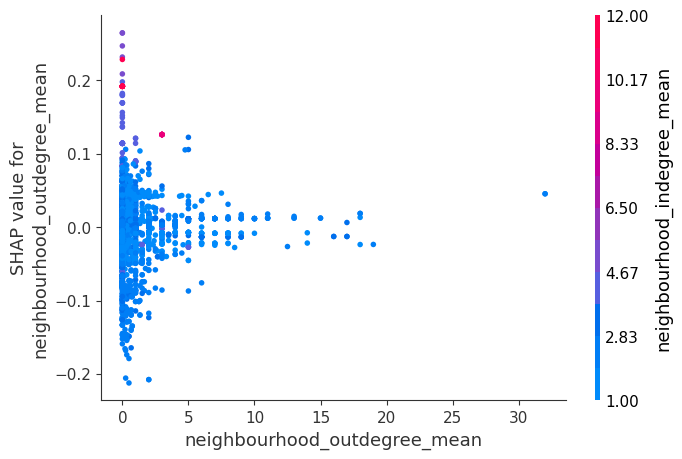

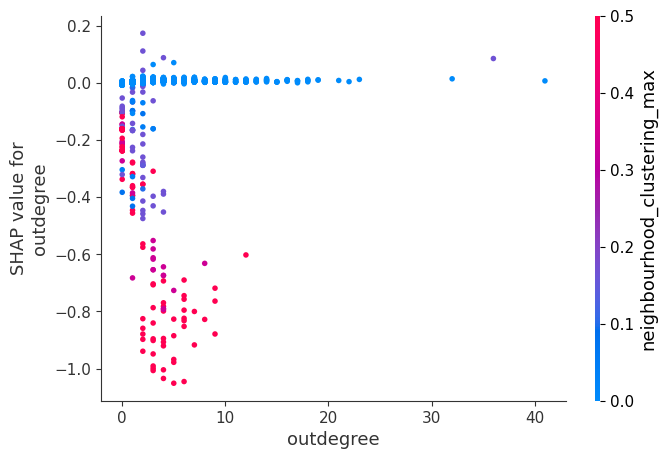

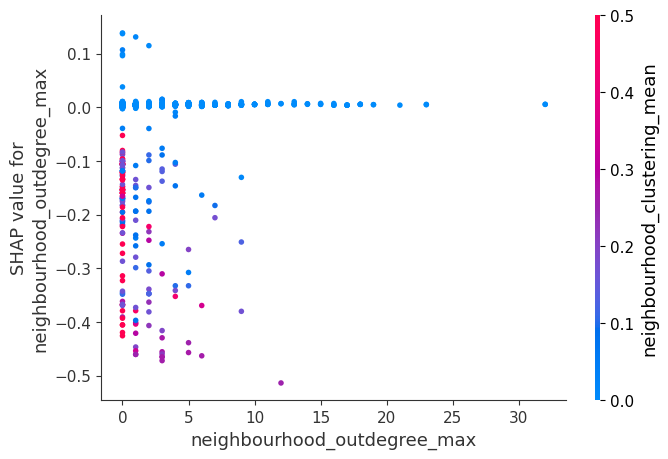

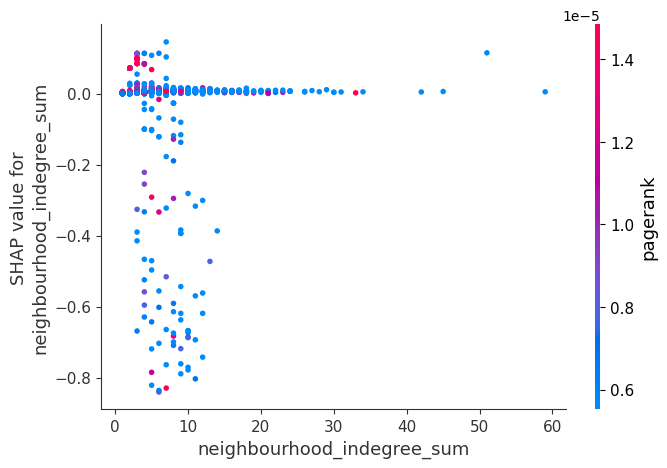

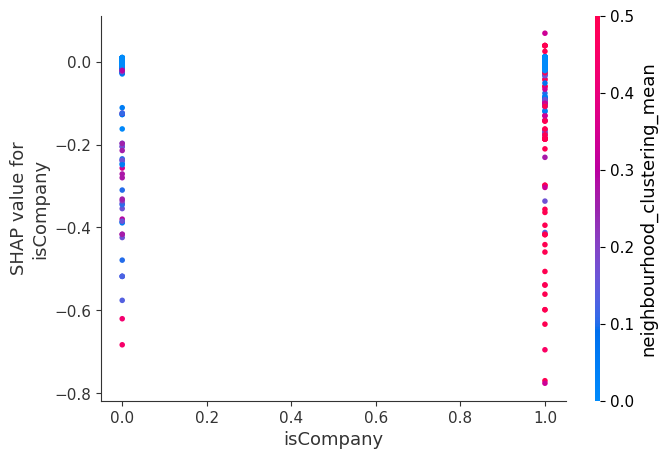

In [34]:
for i in range(X_test.shape[1]):
    shap.dependence_plot(f"rank({i})", shap_values, X_test)
    plt.show()